In [1]:
import math
import lmfit
import json
import os
import numpy as np
import pandas as pd
from math import log
from pandas import Series
from scipy import optimize
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq

# 修改回归图颜色

In [2]:
def union_data(x_data, y_data, posi):
    """
    间隔为0.2
    """
    interval = 0.2
    X = []
    Y = []
    if posi == 1:
        x_y = {round(i, 1): [] for i in np.arange(0, 6.4 + interval, interval)}
    elif posi == -1:
        x_y = {round(i, 1): [] for i in np.arange(-8.0, interval, interval)}
    
    for x, y in zip(x_data, y_data):
        k = round(int(x / interval) * interval, 1) # 取 interval
        try:
            x_y[k].append(y)
        except:
            pass
    
    for x in x_y:
        y_list = x_y[x]
        if y_list:
            y = np.array(y_list).mean()
        else:
            y = -1
#         x_y[x] = y
        X.append(x)
        Y.append(y)
    
    last = 10000
    for i in range(len(Y)): 
        if Y[i] != -1:
            last = Y[i]
        if Y[i] == -1: # 找到第一个0
            for j in range(i+1, len(Y)): 
                if Y[j] != -1: # 找到最近的一个非0
                    now = Y[j]
                    break
            else:
                for m in range(i, len(Y)):
                    Y[m] = last
                return X, Y

            gap = (now - last) / (j - i + 1)
            for k in range(i, j):
                Y[k] = last + gap * (k - i + 1)
    return X, Y


def my_line(x_n, y_n, x, y, **kw):
    '''
    牛熊市下用户行为的差异
    :param x_n: 收益率小于0
    :param y_n:
    :param x: 收益率大于0
    :param y:
    :return:
    '''

    def linear(input_x, input_y):
        '''
        线性回归
        :param x:
        :param y:
        :return: 拟合参数
        '''
        clf = LinearRegression()
        X = [[i] for i in input_x.tolist()]
        y = input_y.tolist()
        clf.fit(X, y)
        return clf.coef_[0], clf.intercept_, clf.score(X, y)
    
    def liner_model(k, b):
        def model(x):
            return b + k * x
        return model
    
    
    res = {}
    plt.figure(figsize=(9, 5))
    
    plt.scatter(x_n, y_n, alpha=0.3, c = '#4ea64e', label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, c = '#fb5050',label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    #plt.plot(union_x_n, union_y_n, c='grey')
    #plt.plot(union_x, union_y, c='grey')
    
    
    # 正
    print('return > 0')
    
    # 画拟合直线
    print('---------- 收益率 < 0 ----------')
    a_n, b_n, r2 = linear(x_n, y_n)
    print('相关性：', x_n.corr(y_n))
    print('参数：', a_n, b_n)
    res['k_n'] = a_n
    res['b_n'] = b_n
    print('R^2：', r2)
    mod_n = liner_model(a_n, b_n)
    p_0 = mod_n(0)
    p_8 = mod_n(-8)
    p_4 = mod_n(4)
    plt.plot([-8, 0], [p_8, p_0], '-', c = '#008000', linewidth=2)
    plt.plot([0, 4], [p_0, p_4], '--', c = '#008000', linewidth=2)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', 1000), ('b', 1000))
    def residual(p):
        return p['k'] * x_n + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))

    print('---------- 收益率 > 0 ----------')
    a, b, r2 = linear(x, y)
    print('相关性：', x.corr(y))
    print('参数：', a, b)
    res['k'] = a
    res['b'] = b
    print('R^2：', r2)
    mod = liner_model(a, b)
    p_0 = mod(0)
    p_8 = mod(8)
    plt.plot([0, 8], [p_0, p_8], '-',c = '#ff0000',linewidth=1.8)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', -1000), ('b', 1000))
    def residual(p):
        return p['k'] * x + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    
    
    print('- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -')
    print('斜率比例：', a_n / a)
    the_point = (b - b_n) / (a_n - a)
    print('平衡点：', the_point)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    plt.scatter(the_point, mod(the_point), c='k', linewidths=3, zorder=100, label='balance point')
    
    plt.xlim(-9, 9)
    plt.xlabel('$r$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
#     plt.savefig('C:/Users/Lenovo/Desktop/pdf_figure/original.pdf',dpi = 300)
    plt.show()
    plt.close('all')
    
    
    # -----------------------------------------------------
    
    print('收益率为0：', mod_n(0) / mod(0))
    print('收益率为1：', mod_n(-1) / mod(1))
    print('收益率为2：', mod_n(-2) / mod(2))
    print('收益率为4：', mod_n(-4) / mod(4))
    print('收益率为6：', mod_n(-6) / mod(6))
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_n(-i) / mod(i) for i in x]
    res['y_ratio'] = y
    plt.plot(x, y)
    plt.show()
    plt.close('all')
    
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    len_union_x = len(union_x)
#     print(union_x_n, union_y_n)
#     print(union_x, union_y)
    union_y_n.reverse()
    union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]
    res['union_y_ratio'] = union_ratio
    res['union_x'] = union_x
    plt.plot(union_x, union_ratio)
#     plt.legend(loc=1)
    plt.show()
    plt.close('all')
    
    res['union_y_n'] = union_y_n
    res['union_y'] = union_y 
    
    
    # 返回可以评估
    res['ratio'] = a_n / a
    res['point'] = the_point
    

    
    return res
    

    

In [3]:
def my_nonlinear_model(p):
    def this_model(x):
        return p['A1'] * (x ** p['A2']) + p['b']
    return this_model


def my_nonline(x_n, y_n, x, y, **kw):
    """
    拟合损失厌恶曲线
    注意：需要初始化参数
    """
    plt.figure(figsize=(12, 5))
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    # 正
    print('return > 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', 1000), ('A2', 1), ('b', 4000))
    def residual(p):
        return p['A1'] * (x ** p['A2']) + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci1 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci1)
    
    mod_1 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 6, 0.1)
    y_fit = [mod_1(x) for x in x_fit]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2)

    print('- * - ' * 15)

    # 负
    print('return < 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', -kw['k_n']), ('A2', 1.5), ('b', kw['b_n']))
    x_n = [-x for x in x_n]
    def residual(p):
        return p['A1'] * (x_n ** p['A2']) + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci2 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci2)

    mod_2 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 8, 0.1)
    y_fit = [mod_2(x) for x in x_fit]
    x_fit = [-x for x in x_fit]
    plt.plot(x_fit, y_fit, '-', c='purple', linewidth=2)
    
    
    # 画图配置及输出
    plt.xlim(-9, 9)
    plt.xlabel('$r$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    # 比值
    print('收益率为0.5：', mod_2(0.5) / mod_1(0.5))
    print('收益率为1：', mod_2(1) / mod_1(1))
    print('收益率为2：', mod_2(2) / mod_1(2))
    print('收益率为4：', mod_2(4) / mod_1(4))
    print('收益率为6：', mod_2(6) / mod_1(6))
    

    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_2(i) / mod_1(i) for i in x]
    kw['non_y_ratio'] = y
    plt.plot(np.arange(0, 10, 1), [1] * 10)
    plt.plot(x, y)
    plt.plot(kw['union_x'], kw['union_y_ratio'])
#     plt.legend(loc=1)
    plt.plot(np.arange(0, 10, 1), [1] * 10, alpha=0.1, linewidth=4)
    plt.show()
    plt.close('all')
    
    return kw



In [4]:
# 合并线性和非线性分析

def my_analysis(x_n, y_n, x, y, **kw):
    res = my_line(x_n, y_n, x, y, **kw)
    res = dict(kw, **res)
    res = my_nonline(x_n, y_n, x, y, **res)
    return res

In [5]:
olhc_n = pd.read_csv('C:/Users/Lenovo/yan/D/金融数据整理（2021）/olhc_n.csv')

收益率与微博总量
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5207391111575157
参数： -5650.277050865203 27243.865854343396
R^2： 0.2711692218891194
[[Variables]]
    k: -5650.27705 +/- 1157.90496 (20.49%) (init = 1000)
    b:  27243.8659 +/- 3411.99940 (12.52%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.3993693144868736
参数： 4033.473584172523 24530.50355366506
R^2： 0.15949584935371575
[[Variables]]
    k:  4033.47358 +/- 912.338170 (22.62%) (init = -1000)
    b:  24530.5036 +/- 2002.76450 (8.16%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.4008464250359958
平衡点： 0.280197456847025


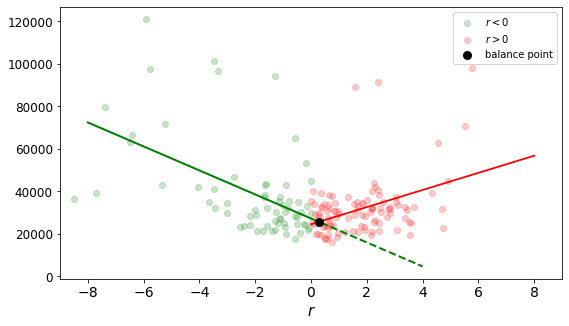

收益率为0： 1.1106117652555458
收益率为1： 1.1515953379487556
收益率为2： 1.182436635452853
收益率为4： 1.2257644682752458
收益率为6： 1.2547473927896038


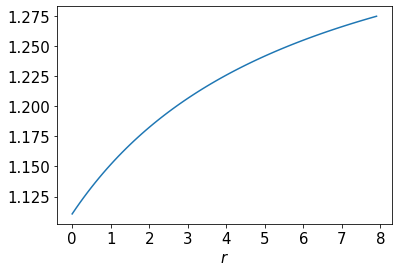

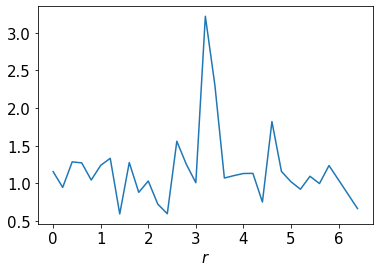

return > 0
[[Variables]]
    A1:  8.0930e-04 +/- 0.00445211 (550.12%) (init = 1000)
    A2:  10.4042332 +/- 3.17387801 (30.51%) (init = 1)
    b:   30154.5194 +/- 1122.05242 (3.72%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.226
    C(A2, b)  = 0.222
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  5968.41016 +/- 6031.32940 (101.05%) (init = 5650.277)
    A2:  0.97373771 +/- 0.47511904 (48.79%) (init = 1.5)
    b:   26946.2903 +/- 6500.16880 (24.12%) (init = 27243.87)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.979
    C(A1, b)  = -0.906
    C(A2, b)  = 0.844


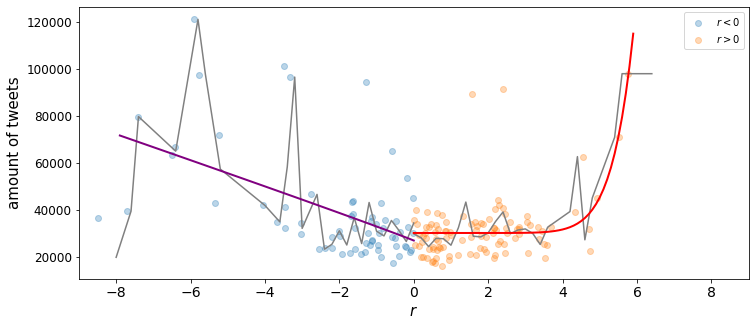

收益率为0.5： 0.9943887929010639
收益率为1： 1.0915345413647906
收益率为2： 1.2822746742008422
收益率为4： 1.5791792915317788
收益率为6： 0.46606485205137993


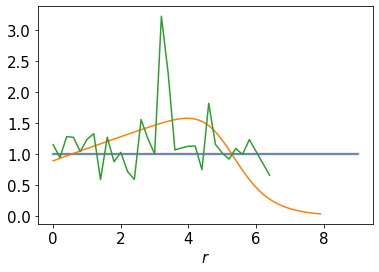

In [7]:
print("收益率与微博总量")
x_n = olhc_n.close[olhc_n.close<0]
y_n = olhc_n.su[olhc_n.close<0]
x = olhc_n.close[olhc_n.close>0]
y = olhc_n.su[olhc_n.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与微博转发量
return > 0
---------- 收益率 < 0 ----------
相关性： -0.44819468640552795
参数： -2006.2221155521577 5498.354704772203
R^2： 0.20087847692214955
[[Variables]]
    k: -2006.22212 +/- 500.182781 (24.93%) (init = 1000)
    b:  5498.35470 +/- 1473.88900 (26.81%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.24168620455715653
参数： 1325.3987274531544 4467.827809848481
R^2： 0.05841222147324365
[[Variables]]
    k:  1325.39873 +/- 524.332144 (39.56%) (init = -1000)
    b:  4467.82781 +/- 1151.01378 (25.76%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.5136743939744477
平衡点： 0.3093169791776571


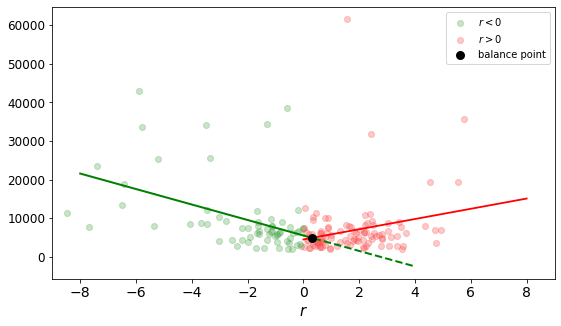

收益率为0： 1.2306550159905718
收益率为1： 1.2954053793690996
收益率为2： 1.3360443318972952
收益率为4： 1.3842417873642747
收益率为6： 1.4118660661098879


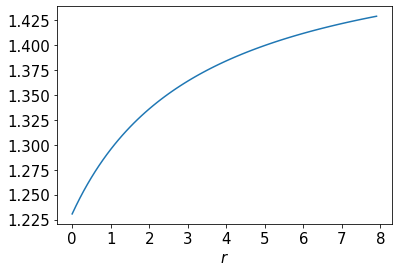

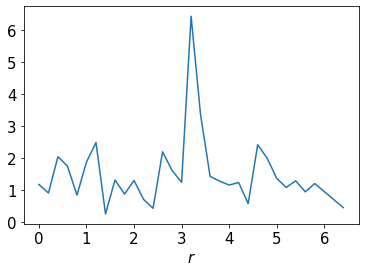

return > 0
[[Variables]]
    A1:  2.4703e-10 +/- 4.8821e-09 (1976.37%) (init = 1000)
    A2:  18.5021890 +/- 11.2595932 (60.86%) (init = 1)
    b:   6349.12449 +/- 662.977744 (10.44%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.145
    C(A2, b)  = 0.143
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  2277.10224 +/- 2737.65626 (120.23%) (init = 2006.222)
    A2:  0.93958443 +/- 0.56160207 (59.77%) (init = 1.5)
    b:   5245.56925 +/- 2902.20000 (55.33%) (init = 5498.355)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.978
    C(A1, b)  = -0.912
    C(A2, b)  = 0.850


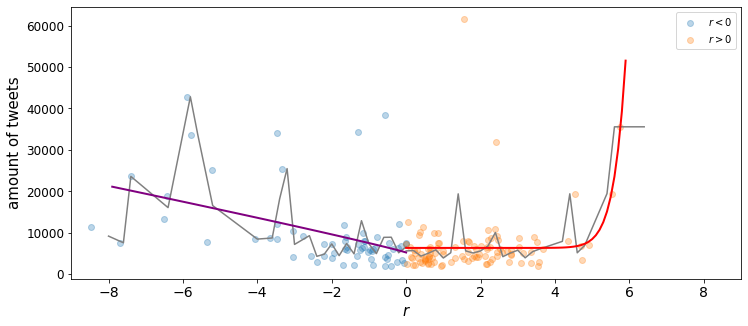

收益率为0.5： 1.0131809122802231
收益率为1： 1.184836034089672
收益率为2： 1.5140663607954021
收益率为4： 2.1340758570018763
收益率为6： 0.25728397266987313


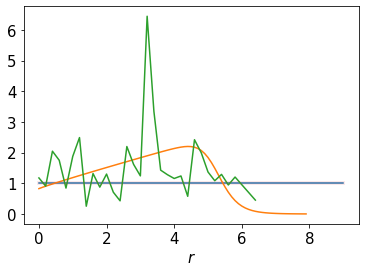

In [8]:
print("收益率与微博转发量")
x_n = olhc_n.close[olhc_n.close<0]
y_n = olhc_n.retweeted[olhc_n.close<0]
x = olhc_n.close[olhc_n.close>0]
y = olhc_n.retweeted[olhc_n.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与微博原创量
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5319147134502593
参数： -3644.0549353130473 21745.511149571183
R^2： 0.28293326238487115
[[Variables]]
    k: -3644.05494 +/- 725.158124 (19.90%) (init = 1000)
    b:  21745.5111 +/- 2136.82399 (9.83%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.46507310015690223
参数： 2708.0748567193687 20062.67574381658
R^2： 0.21629298848955214
[[Variables]]
    k:  2708.07486 +/- 507.922789 (18.76%) (init = -1000)
    b:  20062.6757 +/- 1114.99197 (5.56%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.345625630056456
平衡点： 0.26492459393153633


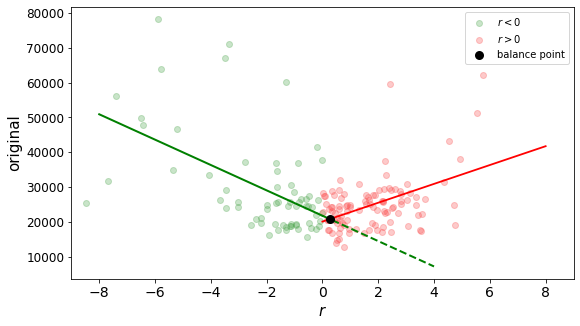

收益率为0： 1.0838789116288867
收益率为1： 1.1150078682204987
收益率为2： 1.1395196010469824
收益率为4： 1.1756517262158848
收益率为6： 1.201004950978703


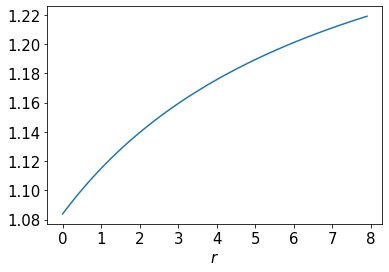

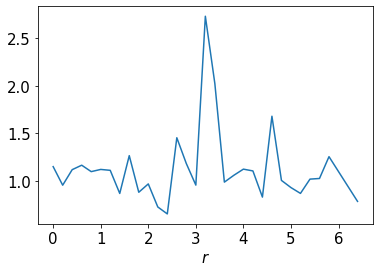

return > 0
[[Variables]]
    A1:  0.02169583 +/- 0.07827967 (360.81%) (init = 1000)
    A2:  8.21477017 +/- 2.09176071 (25.46%) (init = 1)
    b:   23788.3940 +/- 636.630071 (2.68%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.999
    C(A1, b)  = -0.273
    C(A2, b)  = 0.267
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  3721.06918 +/- 3689.61637 (99.15%) (init = 3644.055)
    A2:  0.98993955 +/- 0.46769312 (47.24%) (init = 1.5)
    b:   21673.4812 +/- 4009.21812 (18.50%) (init = 21745.51)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.979
    C(A1, b)  = -0.903
    C(A2, b)  = 0.842


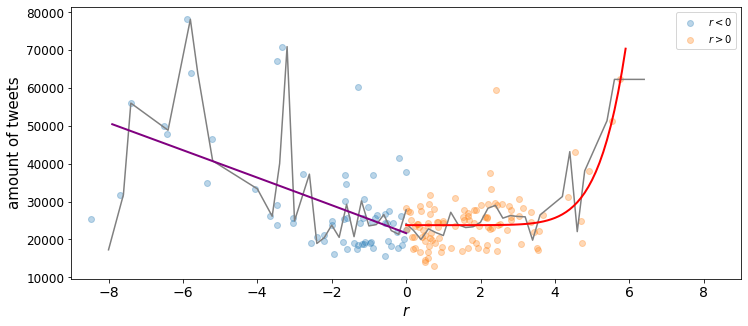

收益率为0.5： 0.9898539265614105
收益率为1： 1.0675175117505205
收益率为2： 1.2214372383024839
收益率为4： 1.4142747776220936
收益率为6： 0.5638142794835799


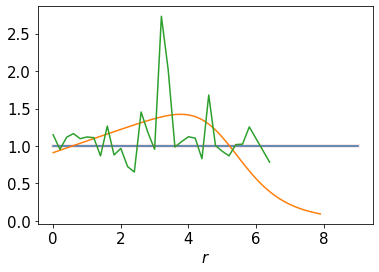

In [13]:
print("收益率与微博原创量")
x_n = olhc_n.close[olhc_n.close<0]
y_n = olhc_n.original[olhc_n.close<0]
x = olhc_n.close[olhc_n.close>0]
y = olhc_n.original[olhc_n.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

DDJ DAJ DSJ DFJ的回归结果补充

In [6]:
hddf = pd.read_csv('C:/Users/Lenovo/yan/D/数据/hddf.csv',encoding = 'utf-8-sig')

收益率与DDJ
return > 0
---------- 收益率 < 0 ----------
相关性： -0.2533006543972641
参数： -0.015728184343008083 -0.4181589034991194
R^2： 0.06416122151808212
[[Variables]]
    k: -0.01572819 +/- 0.00432379 (27.49%) (init = 1000)
    b: -0.41815891 +/- 0.01078496 (2.58%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.16476790546075382
参数： 0.014305585043582453 -0.3978148413648865
R^2： 0.027148462669923656
[[Variables]]
    k:  0.01430559 +/- 0.00538389 (37.63%) (init = -1000)
    b: -0.39781484 +/- 0.00983025 (2.47%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.0994436295399057
平衡点： -0.6773729222052329


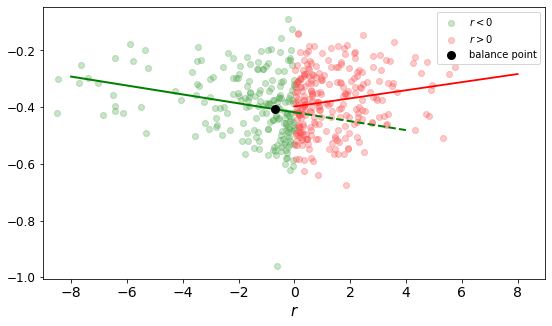

收益率为0： 1.0511395252737008
收益率为1： 1.0493376953044253
收益率为2： 1.0473962338316476
收益率为4： 1.043024038654133
收益率为6： 1.037849913313453


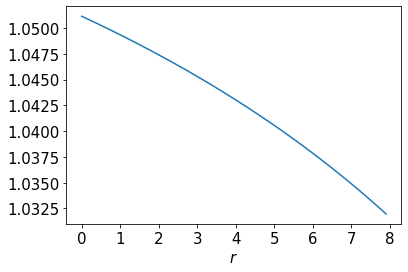

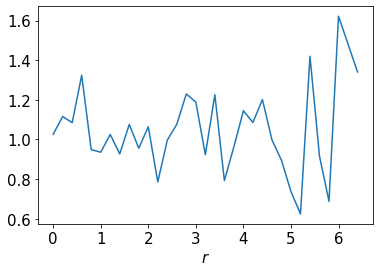

return > 0
[[Variables]]
    A1:  0.01867552 +/- 0.02441334 (130.72%) (init = 1000)
    A2:  0.82978875 +/- 0.79140571 (95.37%) (init = 1)
    b:  -0.40106745 +/- 0.02064893 (5.15%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.958
    C(A1, b)  = -0.935
    C(A2, b)  = 0.854
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.04355827 +/- 0.04068636 (93.41%) (init = 0.01572818)
    A2:  0.53374758 +/- 0.38812668 (72.72%) (init = 1.5)
    b:  -0.44107599 +/- 0.03596948 (8.15%) (init = -0.4181589)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.970
    C(A1, A2) = -0.960
    C(A2, b)  = 0.908


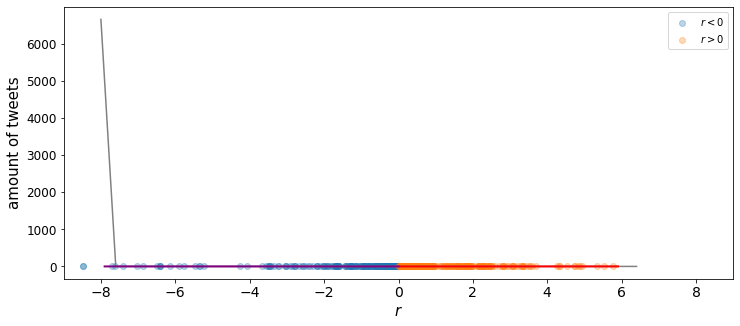

收益率为0.5： 1.0523027416166313
收益率为1： 1.0395557276764262
收益率为2： 1.0275753532675114
收益率为4： 1.0225685038841015
收益率为6： 1.0290803023703443


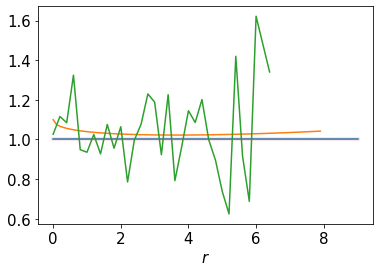

In [25]:
print("收益率与DDJ")
x_n = hddf.close[hddf.close<0]
y_n = hddf.DDJ[hddf.close<0]
x = hddf.close[hddf.close>0]
y = hddf.DDJ[hddf.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与DAJ
return > 0
---------- 收益率 < 0 ----------
相关性： -0.46646934427134373
参数： -0.043586131288346194 -0.5178415234622664
R^2： 0.21759364914493773
[[Variables]]
    k: -0.04358613 +/- 0.00594926 (13.65%) (init = 1000)
    b: -0.51784153 +/- 0.01483943 (2.87%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.1974422921004023
参数： 0.023463152198113846 -0.49975759920703255
R^2： 0.03898345870986064
[[Variables]]
    k:  0.02346315 +/- 0.00732405 (31.22%) (init = -1000)
    b: -0.49975760 +/- 0.01337272 (2.68%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.8576417576087663
平衡点： -0.26971092478394254


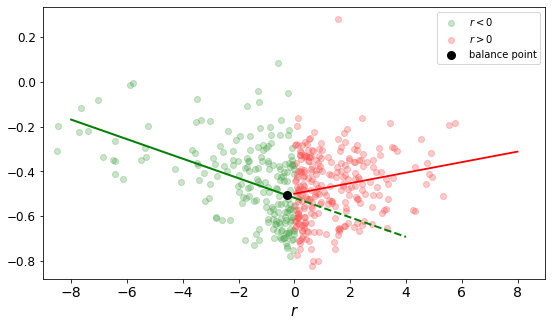

收益率为0： 1.0361853912455312
收益率为1： 0.9957189195721186
收益率为2： 0.9510589612970758
收益率为4： 0.8462497540570906
收益率为6： 0.7140388711520523


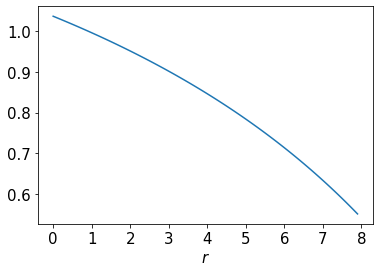

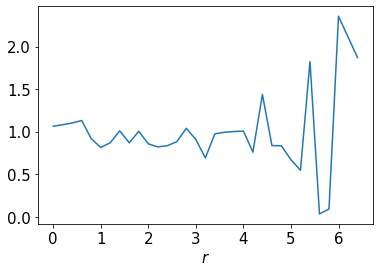

return > 0
[[Variables]]
    A1:  0.01687629 +/- 0.02009158 (119.05%) (init = 1000)
    A2:  1.22095910 +/- 0.76818442 (62.92%) (init = 1)
    b:  -0.49503186 +/- 0.01868745 (3.77%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.965
    C(A1, b)  = -0.842
    C(A2, b)  = 0.750
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.11010242 +/- 0.05169238 (46.95%) (init = 0.04358613)
    A2:  0.56584507 +/- 0.20053862 (35.44%) (init = 1.5)
    b:  -0.57188626 +/- 0.04554560 (7.96%) (init = -0.5178415)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.965
    C(A1, A2) = -0.960
    C(A2, b)  = 0.900


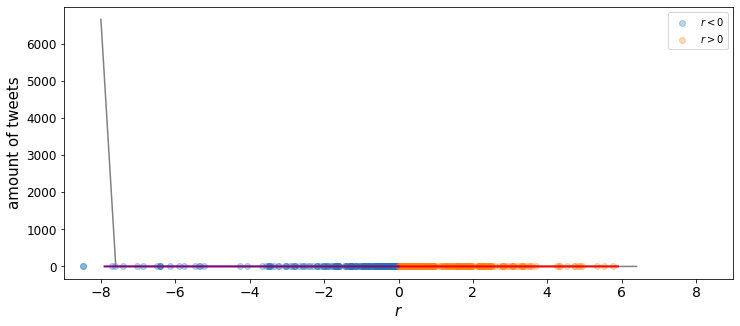

收益率为0.5： 1.0199132741550885
收益率为1： 0.9657606484657225
收益率为2： 0.8973293601402584
收益率为4： 0.8197584698750364
收益率为6： 0.7789549596811606


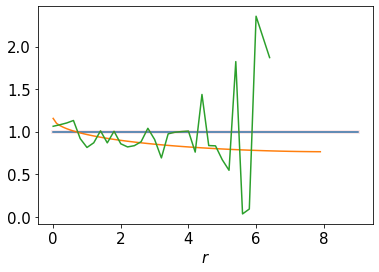

In [26]:
print("收益率与DAJ")
x_n = hddf.close[hddf.close<0]
y_n = hddf.DAJ[hddf.close<0]
x = hddf.close[hddf.close>0]
y = hddf.DAJ[hddf.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与DSJ
return > 0
---------- 收益率 < 0 ----------
相关性： -0.6977404902112873
参数： -0.09284664355903634 -1.009386778571978
R^2： 0.48684179168028774
[[Variables]]
    k: -0.09284665 +/- 0.00686150 (7.39%) (init = 1000)
    b: -1.00938678 +/- 0.01711487 (1.70%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.38741396668966777
参数： 0.05759810100552049 -0.9873187767752034
R^2： 0.15008958158622332
[[Variables]]
    k:  0.05759810 +/- 0.00861706 (14.96%) (init = -1000)
    b: -0.98731878 +/- 0.01573358 (1.59%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.6119740397367865
平衡点： -0.14668509598422666


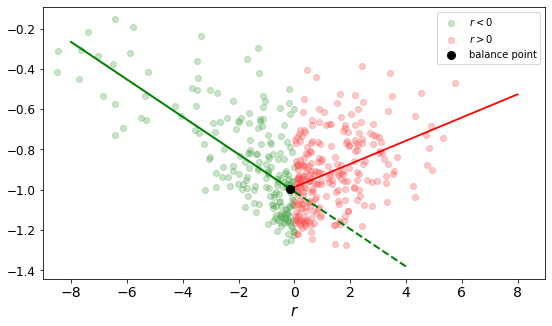

收益率为0： 1.0223514454661273
收益率为1： 0.9858231175230887
收益率为2： 0.9444698661500038
收益率为4： 0.842882778697846
收益率为6： 0.7048241423567847


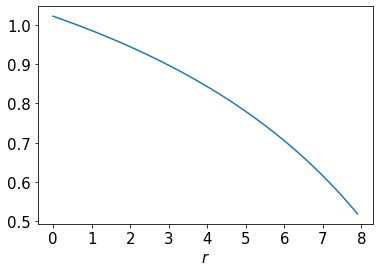

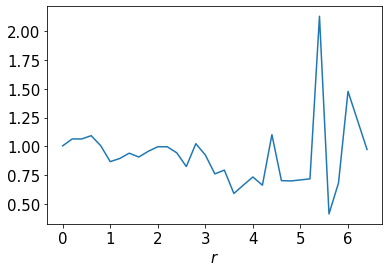

return > 0
[[Variables]]
    A1:  0.05820338 +/- 0.03111481 (53.46%) (init = 1000)
    A2:  0.99313642 +/- 0.33762013 (34.00%) (init = 1)
    b:  -0.98775929 +/- 0.02687716 (2.72%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.960
    C(A1, b)  = -0.898
    C(A2, b)  = 0.809
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.16513728 +/- 0.04448987 (26.94%) (init = 0.09284664)
    A2:  0.71925015 +/- 0.12503179 (17.38%) (init = 1.5)
    b:  -1.06681742 +/- 0.03928242 (3.68%) (init = -1.009387)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.963
    C(A1, b)  = -0.935
    C(A2, b)  = 0.863


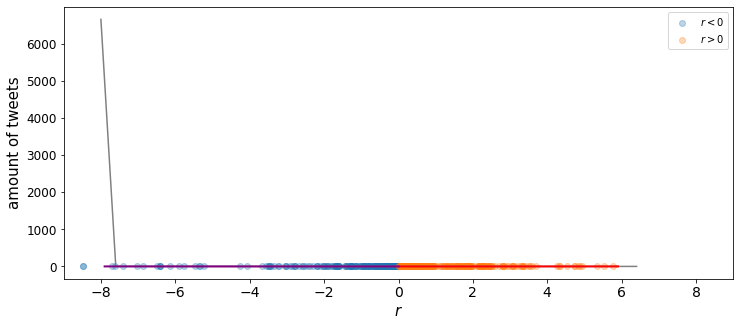

收益率为0.5： 1.0083379257849132
收益率为1： 0.9700117322911844
收益率为2： 0.9117364648949972
收益率为4： 0.8178440742789977
收益率为6： 0.7275497501090151


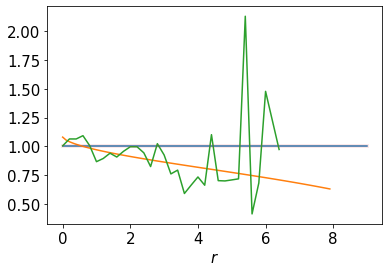

In [27]:
print("收益率与DSJ")
x_n = hddf.close[hddf.close<0]
y_n = hddf.DSJ[hddf.close<0]
x = hddf.close[hddf.close>0]
y = hddf.DSJ[hddf.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与DFJ
return > 0
---------- 收益率 < 0 ----------
相关性： -0.39587181947768363
参数： -0.027916247569688364 0.01925694529464972
R^2： 0.15671449745657162
[[Variables]]
    k: -0.02791625 +/- 0.00466134 (16.70%) (init = 1000)
    b:  0.01925694 +/- 0.01162694 (60.38%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： -0.025366712670632403
参数： -0.0025542691235376953 0.009272056209937058
R^2： 0.0006434701117143948
[[Variables]]
    k: -0.00255427 +/- 0.00632852 (247.76%) (init = -1000)
    b:  0.00927205 +/- 0.01155502 (124.62%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： 10.929250685622353
平衡点： 0.39369519637093314


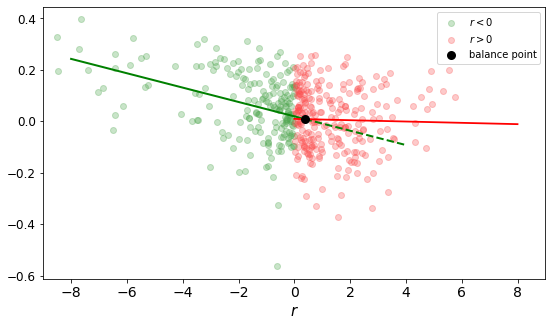

收益率为0： 2.076879697300761
收益率为1： 7.022132773431234
收益率为2： 18.035094625223138
收益率为4： -138.53875706205923
收益率为6： -30.85035516671717


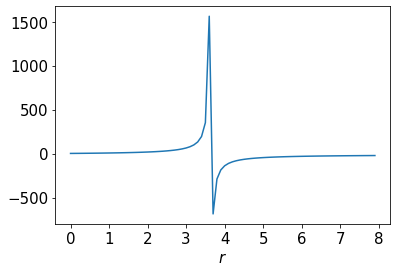

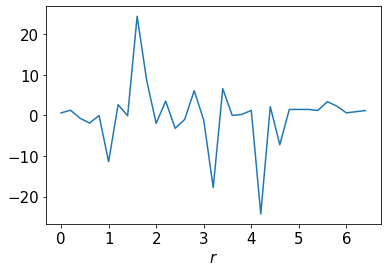

return > 0
[[Variables]]
    A1: -28.2667216 +/- 48167.1380 (170402.28%) (init = 1000)
    A2:  3.8509e-04 +/- 0.70834602 (183944.24%) (init = 1)
    b:   28.2696477 +/- 48167.1333 (170384.62%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A2, b)  = -1.000
    C(A1, A2) = 1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.03269349 +/- 0.02250412 (68.83%) (init = 0.02791625)
    A2:  0.92048625 +/- 0.33712674 (36.62%) (init = 1.5)
    b:   0.01551414 +/- 0.02082427 (134.23%) (init = 0.01925695)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.970
    C(A1, b)  = -0.887
    C(A2, b)  = 0.815


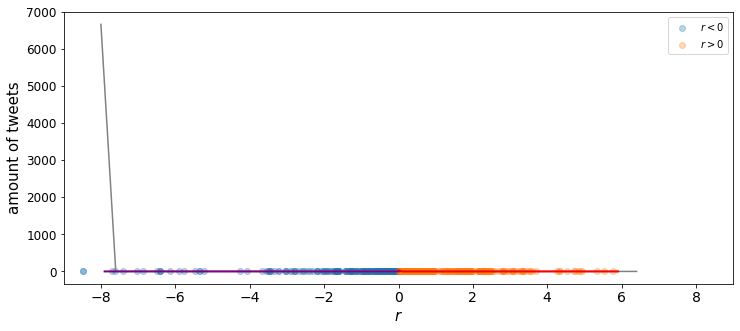

收益率为0.5： 3.1314865970088595
收益率为1： 16.474838401637978
收益率为2： -16.752544231822693
收益率为4： -10.900713061902321
收益率为6： -11.193058623227271


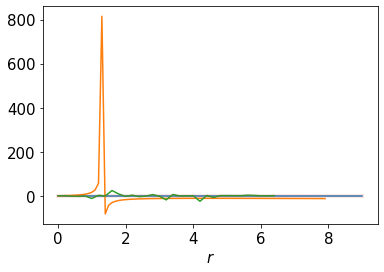

In [28]:
print("收益率与DFJ")
x_n = hddf.close[hddf.close<0]
y_n = hddf.DFJ[hddf.close<0]
x = hddf.close[hddf.close>0]
y = hddf.DFJ[hddf.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

DNP回归结果补充

收益率与DNP
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5819992696759533
参数： -0.03615511479346739 0.2899057675824092
R^2： 0.3387231499033425
[[Variables]]
    k: -0.03615512 +/- 0.00363631 (10.06%) (init = 1000)
    b:  0.28990577 +/- 0.00907015 (3.13%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.1840021869259706
参数： 0.012287336795622486 0.2932427311200949
R^2： 0.03385680479353992
[[Variables]]
    k:  0.01228734 +/- 0.00412663 (33.58%) (init = -1000)
    b:  0.29324273 +/- 0.00753466 (2.57%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -2.9424695843242525
平衡点： -0.06888510858185477


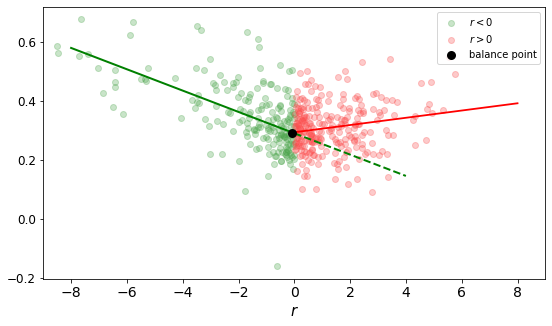

收益率为0： 0.9886204731317992
收益率为1： 1.0671973616221064
收益率为2： 1.1396984299784634
收益率为4： 1.2690896030961076
收益率为6： 1.381150890993663


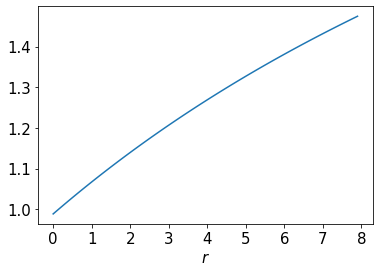

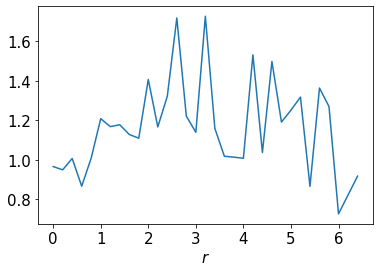

return > 0
[[Variables]]
    A1: -50.6984205 +/- 308944.941 (609377.84%) (init = 1000)
    A2: -1.2895e-04 +/- 0.81298502 (630441.42%) (init = 1)
    b:   51.0098884 +/- 308944.940 (605656.96%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A1, A2) = -1.000
    C(A2, b)  = 1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.05395520 +/- 0.02083577 (38.62%) (init = 0.03615511)
    A2:  0.80196014 +/- 0.18405244 (22.95%) (init = 1.5)
    b:   0.27586296 +/- 0.01864379 (6.76%) (init = 0.2899058)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.966
    C(A1, b)  = -0.916
    C(A2, b)  = 0.843


<ipython-input-4-93145fc6712b>:3: RuntimeWarning: divide by zero encountered in power
  return p['A1'] * (x ** p['A2']) + p['b']


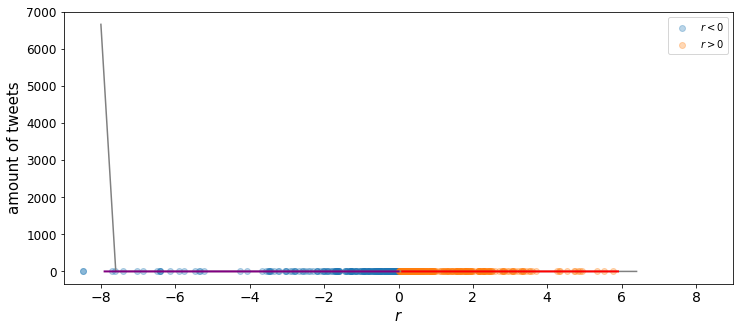

收益率为0.5： 0.9995893812511456
收益率为1： 1.0589153806132563
收益率为2： 1.170673663609602
收益率为4： 1.3723177543860516
收益率为6： 1.5560675173781737


<ipython-input-4-93145fc6712b>:3: RuntimeWarning: divide by zero encountered in power
  return p['A1'] * (x ** p['A2']) + p['b']


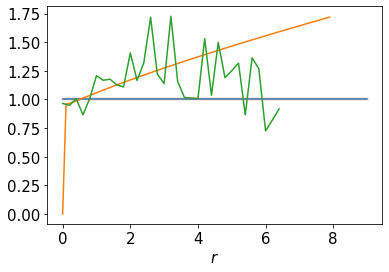

In [7]:
print("收益率与DNP")
x_n = hddf.close[hddf.close<0]
y_n = hddf.DNP[hddf.close<0]
x = hddf.close[hddf.close>0]
y = hddf.DNP[hddf.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

绘制上证收盘指数和动态LAI的双y轴图

In [2]:
#将上证指数450天的文件分割，同60天的滑动窗口，后文件夹更名为index_split_60
csv = pd.read_csv('C:/Users/Lenovo/Desktop/TRD_Index.csv')
n = 60
for i, b in enumerate([csv[i:i+n] for i in range(0,395,5)]):
    b.to_csv(f'C:/Users/Lenovo/Desktop/新建文件夹/{i}.csv')

In [9]:
#将上证指数450天的文件分割，同90天的滑动窗口
csv = pd.read_csv('C:/Users/Lenovo/Desktop/TRD_Index.csv')
n = 90
for i, b in enumerate([csv[i:i+n] for i in range(0,365,5)]):
    b.to_csv(f'C:/Users/Lenovo/Desktop/index_split_90/{i}.csv')

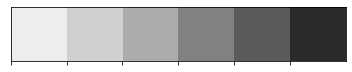

In [123]:
#颜色
sns.palplot(sns.color_palette("Greys"))

In [4]:
import matplotlib.dates as mdates
from matplotlib.pyplot import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter


def remove_outliers(pth):
    data = pd.read_csv(pth,encoding='utf-8-sig')
    
    
    #筛选数据，并进行对数处理
    data['amount of tweets'] = data['slope_ratio'][(data['a_n_minus']<0) & (data['a_plus']>0)]
    data['tweets(log)'] = data['amount of tweets'].map(lambda x: np.sign(x)*log(abs(x)+1))
    data['disgust'] = data['disgust_slope_ratio'][(data['disgust_a_n_minus']<0) & (data['disgust_a_plus']>0)]
    data['disgust(log)'] = data['disgust'].map(lambda x: np.sign(x)*log(abs(x)+1))
    
    #筛选后的数据的均值
    amount_mean = data['tweets(log)'].describe()['mean']
    disgust_mean = data['disgust(log)'].describe()['mean']
    
    sns.axes_style("white")
    fig,axes=plt.subplots(2,1,figsize = (12,12))
    
    data['end_date'] = pd.to_datetime(data['end_date'])
    months = mdates.MonthLocator()
    plt.subplots_adjust(hspace=0.3)  #调整子图上下距离    
    
    ax2 = axes[0].twinx()
    ax3 = axes[1].twinx()
    #上证指数滑动取均值

    sns.lineplot(x='end_date',y='Clsindex',data=data,ax=axes[0],color = 'k',lw = 1)
    sns.lineplot(x='end_date',y='tweets(log)',data=data,ax=ax2,color = '#88bedc',lw = 3)
    
    sns.lineplot(x='end_date',y='Clsindex',data=data,ax=axes[1],color = 'k',lw = 1)
    sns.lineplot(x='end_date',y='disgust(log)',data=data,ax=ax3,color = '#88bedc',lw = 3)

    
    #添加均值线
    ax2.axhline(amount_mean, c='#acacac', ls='--', lw=2)
    ax3.axhline(disgust_mean, c='#acacac', ls='--', lw=2)

       
    #图像配置
    
    fmt = mdates.DateFormatter('%Y/%m')
    axes[0].xaxis.set_major_formatter(fmt)
    axes[1].xaxis.set_major_formatter(fmt)
    
    axes[0].set_xlabel('')
    axes[0].set_ylabel('SSE Index',fontdict={'weight': 'normal', 'size': 15})
    ax2.set_ylabel('$LAI_w$',fontdict={'weight': 'normal', 'size': 15})
    
    axes[1].set_xlabel('')
    axes[1].set_ylabel('SSE Index',fontdict={'weight': 'normal', 'size': 15})
    ax3.set_ylabel('$LAI_d$',fontdict={'weight': 'normal', 'size': 15})
    
    plt.setp(axes[0].get_xticklabels(), rotation=45,ha="right", va="center", rotation_mode="anchor")
    plt.setp(axes[1].get_xticklabels(), rotation=45,ha="right", va="center",rotation_mode="anchor")


    plt.savefig('C:/Users/Lenovo/Desktop/pdf_figure/90_day.pdf',dpi = 300)
    
    return  plt.show()

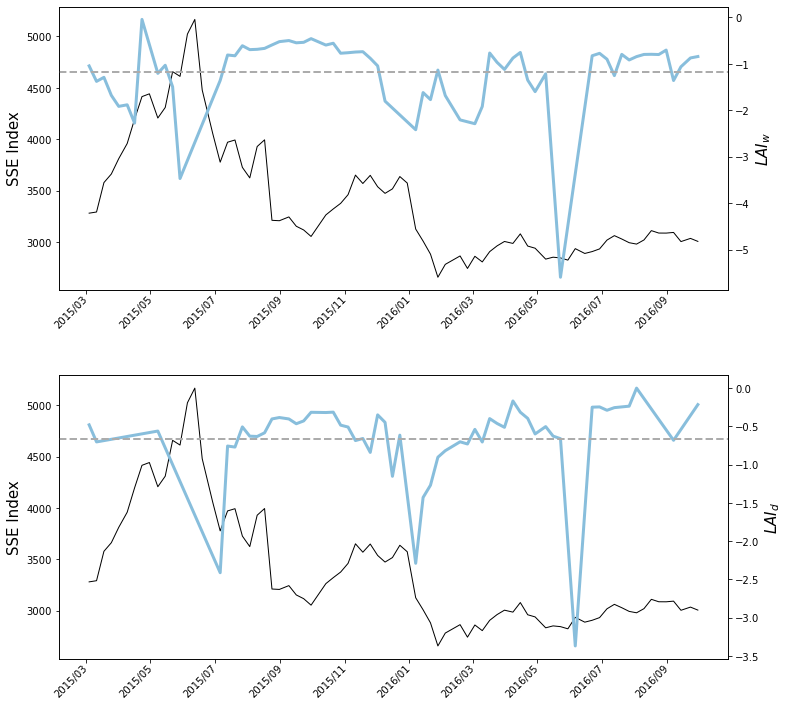

In [3]:
remove_outliers('C:/Users/Lenovo/yan/D/document_60/my_project_60/timeslide60_result/target_day.csv')

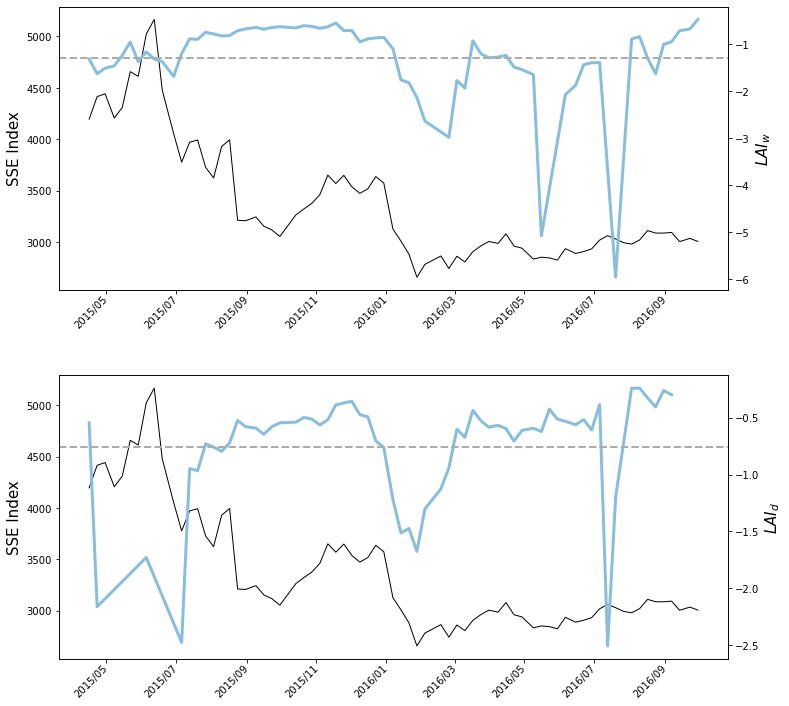

In [5]:
remove_outliers('C:/Users/Lenovo/yan/D/document_90/my_project/timeslide90_result/target_day_90.csv')